In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Load the extension

In [2]:
import gcGroupbyExtension

# Generate some fake data

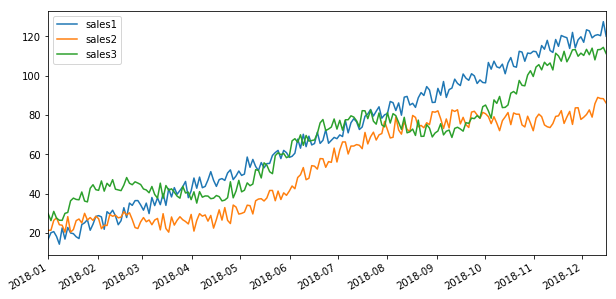

In [3]:
size = 200

df = pd.DataFrame({
    "sales1": np.linspace(10, 120, size) + np.random.rand(size)*10,
    "sales2": np.linspace(8, 90, size) + np.random.rand(size)*10 + np.cos(np.linspace(0, 10, size))*10,
    "sales3": np.linspace(20, 100, size) + np.random.rand(size)*10 + np.sin(np.linspace(0, 15, size))*10,
}, index=pd.date_range("2018/01/01", "2018/12/16", periods=size))

df.plot(figsize=(10, 5))

# 1) Deconstructed Demo

All the steps will be deconstructed to present the functionalities of the extension.

## 1.a) Construct groups based on bi-mensuality. 

Use the `gc` namespace to access the special `groupby` method. 

This method accept the same arguments than a standard `pandas.groubpy` method.

In [4]:
groups = df.gc.groupby(pd.Grouper(freq='3M'))
print("The generated object is a", groups)

The generated object is a <CustomGroupBy object>


### Like for a standard groupby object, the groups can be accessed via the `.groups` property

Note that the `.groups` property gives a list of tuples consisting of (groupLabel, groupData).

In [5]:
print(f"{len(groups.groups)} groups have been created.\n")

gp,d = groups.groups[0]
print(f"Key of the first group: {gp}.\n")
print(f"Data of the first group:\n{d}")

5 groups have been created.

Key of the first group: 2018-01-31 00:00:00.

Data of the first group:
                                  sales1     sales2     sales3
2018-01-01 00:00:00.000000000  16.878932  21.418217  29.919884
2018-01-02 18:05:25.628140703  20.187135  21.467267  26.354822
2018-01-04 12:10:51.256281407  20.772286  26.459732  31.054147
2018-01-06 06:16:16.884422110  18.283813  27.776869  27.602368
2018-01-08 00:21:42.512562814  14.365213  24.253925  26.542911
2018-01-09 18:27:08.140703517  22.639821  24.018431  26.501325
2018-01-11 12:32:33.768844221  16.962782  20.434285  30.041491
2018-01-13 06:37:59.396984924  22.879046  28.385255  30.498001
2018-01-15 00:43:25.025125628  20.047737  20.524289  36.419240
2018-01-16 18:48:50.653266331  19.716553  21.803245  37.793851
2018-01-18 12:54:16.281407035  18.144372  26.345409  37.126332
2018-01-20 06:59:41.909547738  17.235883  27.172248  36.932740
2018-01-22 01:05:07.537688442  24.338078  25.167445  40.906343
2018-01-23 19:10:3

### Let's visualize what those groups are

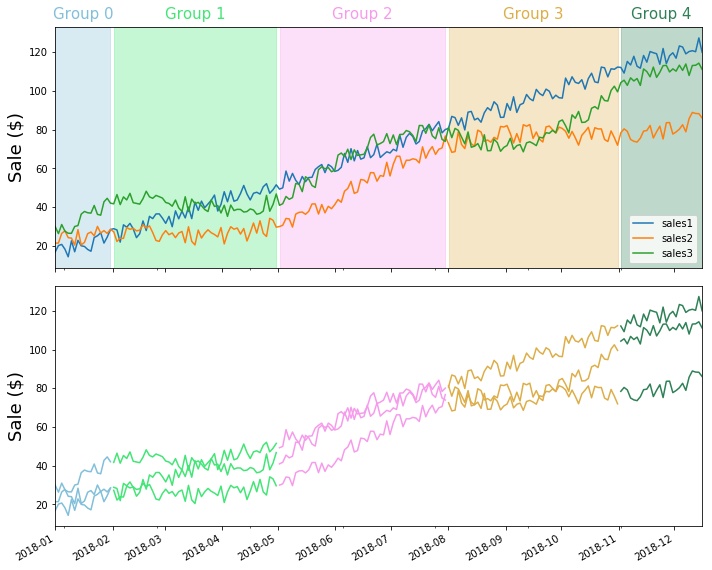

In [6]:
colors = ["#81BFDA", "#42E576", "#F69BEC", "#DDAE48", "#2E8156"]

fig,axes = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)
ax1,ax2 = axes

# Top panel
df.plot(ax=ax1)
for i,(gp,data) in enumerate(groups.transformedGroups):
    ax1.axvspan(data.index[0], data.index[-1], alpha=0.3, color=colors[i])
    ax1.text( data.index[0]+(data.index[-1]-data.index[0])/2, 
             ax1.get_ylim()[0]+(ax1.get_ylim()[1]-ax1.get_ylim()[0])*1.02, 
             f"Group {i}", ha="center", va="bottom", size=15, color=colors[i])
    
# Bottom panel
concatenated = groups.concat(axis=1)
level0 = concatenated.columns.get_level_values(0).unique()
for i,gp in enumerate(level0):
    concatenated[gp].plot(legend=False, color=colors[i], ax=ax2)
    
for ax in axes:
    ax.set_ylabel("Sale ($)", size=18)
    
fig.tight_layout()

We now have 5 groups. Note that no transformation has been applied yet, so each group is a Pandas Dataframe reflecting the corresponding slice of the original DataFrame.

### This groupby object also has a `.transformedGroups` property that gives access to the groups after the pipeline of transformation(s) has been applied

So far we haven't applied any transformations to our groups, so `.groups` and `.transformedGroups` are similar groups of dataFrame slices.

In [7]:
for i in range(len(groups.groups)):
    print(np.unique((groups.transformedGroups[i][1] == groups.groups[i][1]).values))

[ True]
[ True]
[ True]
[ True]
[ True]


## 1.b) Let's define some function

In [8]:
def subtractRow(df, pos=0):
    '''Make a subtraction column-wise of the value at the specified row position'''
    return df-df.iloc[pos]

def multiplySelectedColumnBy(df, column=0, factor=2):
    '''Multiply the specified column by the given factor.
       The column could be and index or name.
    '''
    outDf = df.copy()
    if isinstance(column, int) and column < len(getattr(df, 'columns', [0])):
        outDf.iloc[:, column] = outDf.iloc[:, column] * factor
    elif isinstance(column, str) and column in getattr(df, 'columns', [0]):
        outDf.loc[:, column] = outDf.loc[:, column] * factor
    else:
        raise ValueError(f"The provided column is not of {getattr(df, 'columns', [0])}")
    return outDf 

## 1.c) Let's chain some transformations to be applied on the groups

Note:
 - The functions added to the pipeline using the `.apply` method will not be ran until the `.concat` method is called (see below). The `.apply` method just adds the functions to the list of functions to be applied. This means that you can add your functions in several ways (see cell below).
 
 - you can provide both `lambda` functions or regular functions to the `.apply` method
 
 - several functions can be provided at the same time to the `.apply` method
 
 - you can limit the application of your transformation to some groups only by providing their label to the `onlyGroups=[label1, label3, etc ...]` or `ignoreGroups=[label1, label3, etc ...]` arguments.
 
 - if you want to limit the application of your functions to some groups but are not sure of the name of the group, the `.getLabelForGroup(index)` method of the groupby object allows you to get the labels of each group using their index (see below).

In [9]:
####################################################################################################
# The three examples below have the same result

####################################################################################################
# EX1: adding the functions to the pipeline of our custom groupby object one by one without chaining

# Note : the _clearPipeline method clears the list of transformations to be applied. Usually you do
# not have to call it. It is called here to ensure that the same result will be outputted by the cell
# each time it is run since we are demonstrating several ways to do the same thing.

groups._clearPipeline()
groups.apply(lambda x: x.rolling(5).mean().fillna(method="bfill")) # rolling average over a window of 5 points
groups.apply(lambda x: x.mean(axis=1), onlyGroups=[groups.getLabelForGroup(2)]) # average the values over the columns and concatenate them into a Series
groups.apply(subtractRow, onlyGroups=[groups.getLabelForGroup(2)]) # reset the starting value of the group
groups.apply(lambda x: multiplySelectedColumnBy(x, column='sales2', factor=2), onlyGroups=[groups.getLabelForGroup(4)]) # reset the starting value of the group


####################################################################################################
# EX2: chaining the .apply method

(groups
     ._clearPipeline() 
     .apply(lambda x: x.rolling(5).mean().fillna(method="bfill"))
     .apply(lambda x: x.mean(axis=1), onlyGroups=[groups.getLabelForGroup(2)])
     .apply(subtractRow, onlyGroups=[groups.getLabelForGroup(2)])
     .apply(lambda x: multiplySelectedColumnBy(x, column='sales2', factor=2), onlyGroups=[groups.getLabelForGroup(4)])
)

####################################################################################################
# EX3: chaining the .apply methods. 
# If you limit the scope of some functions to some groups, all the functions provided will be 
# limited to the scoped groups specified

(groups
     ._clearPipeline() 
     .apply(lambda x: x.rolling(5).mean().fillna(method="bfill"))
     .apply(lambda x: x.mean(axis=1), subtractRow, onlyGroups=[groups.getLabelForGroup(2)])
     .apply(lambda x: multiplySelectedColumnBy(x, column='sales2', factor=2), onlyGroups=[groups.getLabelForGroup(4)])
)


<CustomGroupBy object>

## 1.d) Get the resulting DataFrame after transformation (use the `.concat` method)

`.concat` accepts the same arguments as the [pandas.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) method, as well as 3 other arguments:

- ***multiIndex: 'hierarchy' (default) | 'join' | None***. 

How you want the column/index of your concatenated dataFrame to be renamed.
Note that if one of the transformation changes the shape of your DataFrame

- ***sep: '|' (default)***.

If mulitindex='join', which separator do you want in between the different levels of your multiindex in the flatten name.

- ***clearPipeline: True (default) | False***.

Clear any function that has been chained from your groupby object. If `.concat` is applied in his own cell, set clearPipeline to False to be able to get the same result on each cell re-run.

In [10]:
groups.concat(axis=0, clearPipeline=False)

0      sales1      sales2  \
2018-01-31 2018-01-01 00:00:00.000000000 NaN   18.097476   24.275202   
           2018-01-02 18:05:25.628140703 NaN   18.097476   24.275202   
           2018-01-04 12:10:51.256281407 NaN   18.097476   24.275202   
           2018-01-06 06:16:16.884422110 NaN   18.097476   24.275202   
           2018-01-08 00:21:42.512562814 NaN   18.097476   24.275202   
           2018-01-09 18:27:08.140703517 NaN   19.249654   24.795245   
           2018-01-11 12:32:33.768844221 NaN   18.604783   24.588648   
           2018-01-13 06:37:59.396984924 NaN   19.026135   24.973753   
           2018-01-15 00:43:25.025125628 NaN   19.378920   23.523237   
           2018-01-16 18:48:50.653266331 NaN   20.449188   23.033101   
           2018-01-18 12:54:16.281407035 NaN   19.550098   23.498497   
           2018-01-20 06:59:41.909547738 NaN   19.604718   24.846089   
           2018-01-22 01:05:07.537688442 NaN   19.896525   24.202527   
           2018-01-23 19:10:33.165829146 NaN   20.934124   26.110077   
           2018-01-25 13:15:58.793969849 NaN   22.355938   27.081440   
           2018-01-27 07:21:24.422110553 NaN   23.018031   27.391093   
           2018-01-29 01:26:50.050251256 NaN   24.478139   27.252580   
           2018-01-30 19:32:15.678391960 NaN   25.301769   27.926424   
2018-04-30 2018-02-01 13:37:41.306532663 NaN   27.927482   25.387660   
           2018-02-03 07:43:06.934673367 NaN   27.927482   25.387660   
           2018-02-05 01:48:32.562814070 NaN   27.927482   25.387660   
           2018-02-06 19:53:58.190954774 NaN   27.927482   25.387660   
           2018-02-08 13:59:23.819095477 NaN   27.927482   25.387660   
           2018-02-10 08:04:49.447236181 NaN   28.478764   25.632089   
           2018-02-12 02:10:15.075376885 NaN   28.591511   26.998046   
           2018-02-13 20:15:40.703517588 NaN   29.053549   27.755201   
           2018-02-15 14:21:06.331658292 NaN   28.136269   28.604141   
           2018-02-17 08:26:31.959798995 NaN   28.789044   28.883068   
           2018-02-19 02:31:57.587939699 NaN   28.045212   29.015620   
           2018-02-20 20:37:23.216080402 NaN   29.335536   29.262664   
...                                       ..         ...         ...   
2018-10-31 2018-10-26 03:22:36.783919600 NaN  108.180790   78.186628   
           2018-10-27 21:28:02.412060304 NaN  109.532328   77.855952   
           2018-10-29 15:33:28.040201008 NaN  110.920279   76.959199   
           2018-10-31 09:38:53.668341712 NaN  110.921779   75.276095   
2019-01-31 2018-11-02 03:44:19.296482416 NaN  113.668541  154.890637   
           2018-11-03 21:49:44.924623116 NaN  113.668541  154.890637   
           2018-11-05 15:55:10.552763820 NaN  113.668541  154.890637   
           2018-11-07 10:00:36.180904524 NaN  113.668541  154.890637   
           2018-11-09 04:06:01.809045228 NaN  113.668541  154.890637   
           2018-11-10 22:11:27.437185932 NaN  113.789098  152.963729   
           2018-11-12 16:16:53.065326636 NaN  114.296188  151.043371   
           2018-11-14 10:22:18.693467340 NaN  114.912141  151.095164   
           2018-11-16 04:27:44.321608044 NaN  115.203480  152.934214   
           2018-11-17 22:33:09.949748748 NaN  115.694109  156.212254   
           2018-11-19 16:38:35.577889448 NaN  117.091066  157.052300   
           2018-11-21 10:44:01.206030152 NaN  118.586242  158.387329   
           2018-11-23 04:49:26.834170856 NaN  117.675007  159.399942   
           2018-11-24 22:54:52.462311560 NaN  119.091685  157.659732   
           2018-11-26 17:00:18.090452264 NaN  117.837237  158.221215   
           2018-11-28 11:05:43.718592968 NaN  117.528047  161.412041   
           2018-11-30 05:11:09.346733672 NaN  117.625765  160.924750   
           2018-12-01 23:16:34.974874376 NaN  118.253468  159.733512   
           2018-12-03 17:22:00.603015080 NaN  118.518856  161.754586   
           2018-12-05 11:27:26.231155780 NaN  120.242728  161.345069   
           

### Let's visualize the result of our transformation pipeline 

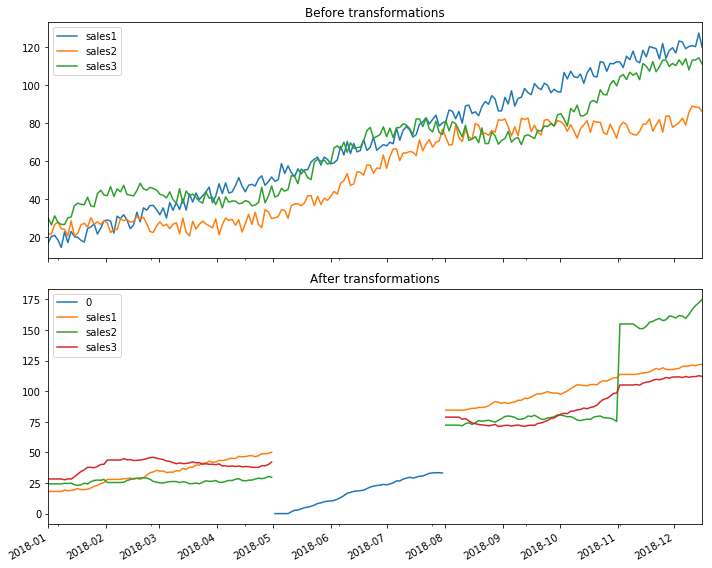

In [11]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)

df.plot(ax=axes[0])
groups.concat(axis=0, multiIndex=None, clearPipeline=False).plot(ax=axes[1], legend=True)

for i,label in enumerate(["Before", "After"]):
    axes[i].set_title(f"{label} transformations")

fig.tight_layout()

# 2) Demo in one go

Of course, you can do all those steps in one go

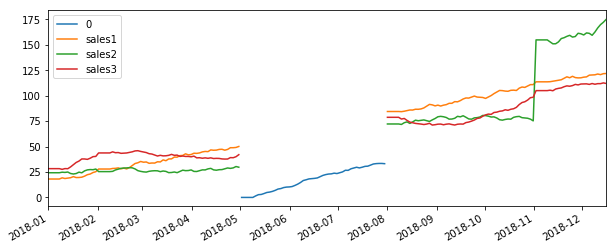

In [12]:
df = df.copy() # reset the gc.groupby object

(df.gc.groupby(pd.Grouper(freq='3M'))
     .apply(lambda x: x.rolling(5).mean().fillna(method="bfill"))
     .apply(lambda x: x.mean(axis=1), onlyGroups=[df.gc.groupby(pd.Grouper(freq='3M')).getLabelForGroup(2)])
     .apply(subtractRow, onlyGroups=[groups.getLabelForGroup(2)])
     .apply(lambda x: multiplySelectedColumnBy(x, column='sales2', factor=2), onlyGroups=[df.gc.groupby(pd.Grouper(freq='3M')).getLabelForGroup(4)])
).concat(axis=0, multiIndex=None).plot(figsize=(10, 4))